In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, log_loss, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from tqdm import tqdm

In [42]:
og_df = pd.read_csv('files/pd_speech_features.csv')
og_df

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,250,0,0.80903,0.56355,0.28385,417,416,0.004627,0.000052,0.00064,...,3.0706,3.0190,3.1212,2.4921,3.5844,3.5400,3.3805,3.2003,6.8671,0
752,250,0,0.16084,0.56499,0.59194,415,413,0.004550,0.000220,0.00143,...,1.9704,1.7451,1.8277,2.4976,5.2981,4.2616,6.3042,10.9058,28.4170,0
753,251,0,0.88389,0.72335,0.46815,381,380,0.005069,0.000103,0.00076,...,51.5607,44.4641,26.1586,6.3076,2.8601,2.5361,3.5377,3.3545,5.0424,0
754,251,0,0.83782,0.74890,0.49823,340,339,0.005679,0.000055,0.00092,...,19.1607,12.8312,8.9434,2.2044,1.9496,1.9664,2.6801,2.8332,3.7131,0


## Pre Processing

In [60]:
X = og_df.drop(columns=['class'])  # Features
y = og_df['class']  # Target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=25)  # change comp numb here
X_pca = pca.fit_transform(X_scaled)

reduced_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
reduced_df['class'] = y 
reduced_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,class
0,-10.047372,1.471076,-6.846403,-0.782090,-3.440105,-0.053203,1.961632,0.938700,0.439710,-0.443619,...,-1.141415,1.625397,1.326693,0.540539,-1.183976,-3.389147,-2.781071,0.377551,1.375578,1
1,-10.637725,1.583749,-6.830977,1.415978,-3.200764,1.724364,2.109032,2.244241,0.611418,1.269869,...,0.081027,-0.374599,-0.467091,1.643286,-3.225786,-1.422928,-2.367640,-0.798644,2.001200,1
2,-13.516185,-1.253543,-6.818697,1.412663,-2.284053,2.567113,0.715762,1.084778,0.094864,-1.507963,...,-1.271957,2.101404,0.663270,1.411521,-0.443733,-1.793031,-2.357929,-0.407774,1.430074,1
3,-9.155084,8.833599,15.290902,-4.036450,-5.139306,-9.570309,-2.916918,-5.211701,-4.798264,5.187665,...,0.588077,0.428380,-0.896340,-0.635766,0.063972,-1.051482,1.320789,1.672161,2.637846,1
4,-6.764470,4.611466,15.637120,-5.847869,-5.794315,-11.050845,-1.310733,-5.386998,-7.927613,7.284760,...,0.799982,-0.699768,0.115516,-0.202096,1.366079,-1.671653,1.857659,1.112558,1.416512,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,22.322682,6.481911,1.458753,11.207483,-4.812518,7.460024,-2.133422,-7.100002,-1.030007,3.470186,...,-0.819688,-3.331512,-0.954828,4.863186,-0.200668,-0.275214,-1.772012,0.360272,0.994150,0
752,13.442877,1.449412,9.352294,8.836102,-3.941492,4.466548,-7.503461,-5.409400,-0.953682,2.405178,...,-0.392073,1.088774,0.567729,0.599861,4.574128,-2.033065,-3.229249,3.272310,-1.419389,0
753,8.270264,2.391285,-0.908670,-2.158860,-0.968911,0.928121,1.859254,-1.332640,0.591748,-0.262455,...,2.417913,-0.020107,-1.232741,1.936244,1.530561,-1.995308,0.515144,-1.569310,-3.319691,0
754,4.011760,5.412257,-0.847132,-3.953490,0.324532,0.784753,0.300617,-0.805557,-0.839898,-0.737000,...,2.808625,-0.311921,-1.586349,-0.148521,2.239602,-1.458608,0.530293,-0.935598,-1.340142,0


### Feature Selection

In [61]:
X = reduced_df.drop(columns=['class'])
y = reduced_df['class']

correlation_coefficients = {}
for column in X.columns:
    correlation, _ = spearmanr(X[column], y)
    correlation_coefficients[column] = abs(correlation)

sorted_features = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

n_features = 19  # change here
selected_features = [feature[0] for feature in sorted_features[:n_features]]

X_selected = X[selected_features]

In [62]:
sorted_features[:n_features]

[('PC1', 0.41851422716497966),
 ('PC6', 0.17065844983144765),
 ('PC5', 0.1393283656179394),
 ('PC22', 0.13185091885231542),
 ('PC17', 0.1282027046016758),
 ('PC7', 0.12703304812437147),
 ('PC3', 0.1229949483812971),
 ('PC19', 0.10799828140443113),
 ('PC13', 0.10652228632592808),
 ('PC10', 0.10643873943469206),
 ('PC8', 0.08020501558658114),
 ('PC11', 0.07198957128170565),
 ('PC25', 0.07109840444185475),
 ('PC24', 0.06962240936335168),
 ('PC20', 0.06293865806446992),
 ('PC21', 0.06267409290888919),
 ('PC14', 0.056213133319970146),
 ('PC16', 0.052913031116147285),
 ('PC2', 0.05204971324004172)]

In [63]:
X_selected

,PC1,PC6,PC5,PC22,PC17,PC7,PC3,PC19,PC13,PC10,PC8,PC11,PC25,PC24,PC20,PC21,PC14,PC16,PC2
0,-10.047372,-0.053203,-3.440105,-3.389147,-1.141415,1.961632,-6.846403,1.326693,0.749695,-0.443619,0.938700,-0.373436,1.375578,0.377551,0.540539,-1.183976,-0.839391,-0.540236,1.471076
1,-10.637725,1.724364,-3.200764,-1.422928,0.081027,2.109032,-6.830977,-0.467091,1.365324,1.269869,2.244241,1.400373,2.001200,-0.798644,1.643286,-3.225786,-0.438499,-1.919813,1.583749
2,-13.516185,2.567113,-2.284053,-1.793031,-1.271957,0.715762,-6.818697,0.663270,0.678267,-1.507963,1.084778,-1.380060,1.430074,-0.407774,1.411521,-0.443733,-0.593393,-0.256433,-1.253543
3,-9.155084,-9.570309,-5.139306,-1.051482,0.588077,-2.916918,15.290902,-0.896340,5.716347,5.187665,-5.211701,5.566673,2.637846,1.672161,-0.635766,0.063972,2.558275,-2.115363,8.833599
4,-6.764470,-11.050845,-5.794315,-1.671653,0.799982,-1.310733,15.637120,0.115516,4.642903,7.284760,-5.386998,1.806232,1.416512,1.112558,-0.202096,1.366079,3.800221,-0.579196,4.611466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,22.322682,7.460024,-4.812518,-0.275214,-0.819688,-2.133422,1.458753,-0.954828,3.005780,3.470186,-7.100002,4.258782,0.994150,0.360272,4.863186,-0.200668,1.373369,-2.477908,6.481911
752,13.442877,4.466548,-3.941492,-2.033065,-0.392073,-7.503461,9.352294,0.567729,3.864005,2.405178,-5.409400,4.026340,-1.419389,3.272310,0.599861,4.574128,-0.577517,-3.759925,1.449412
753,8.270264,0.928121,-0.968911,-1.995308,2.417913,1.859254,-0.908670,-1.232741,-0.384568,-0.262455,-1.332640,1.571260,-3.319691,-1.569310,1.936244,1.530561,0.291925,1.706994,2.391285
754,4.011760,0.784753,0.324532,-1.458608,2.808625,0.300617,-0.847132,-1.586349,0.924630,-0.737000,-0.805557,2.035182,-1.340142,-0.935598,-0.148521,2.239602,2.477802,-0.944515,5.412257


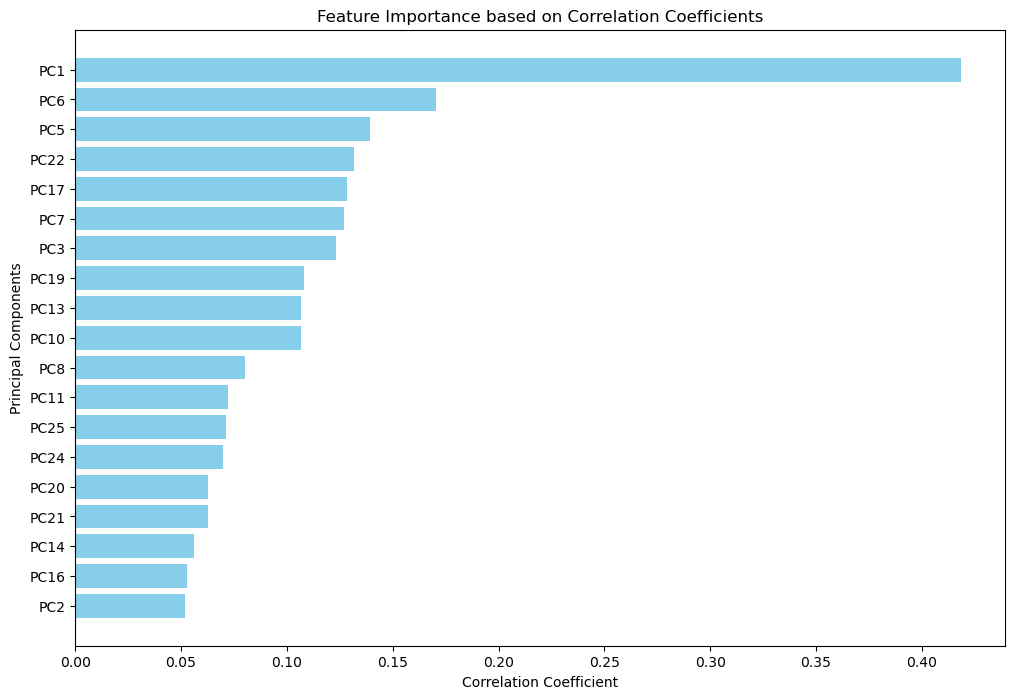

In [64]:
features = [feature[0] for feature in sorted_features[:n_features]]
coefficients = [feature[1] for feature in sorted_features[:n_features]]

plt.figure(figsize=(12, 8))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Principal Components')
plt.title('Feature Importance based on Correlation Coefficients')
plt.gca().invert_yaxis()  # invert y-axis 
plt.show()

# Model Runs:

## RF Modeling Running

In [72]:
X = reduced_df.drop(columns=['class'])
y = reduced_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

In [73]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=28)
rf_classifier.fit(X_train, y_train)

y_train_pred = rf_classifier.predict_proba(X_train)[:, 1]
y_val_pred = rf_classifier.predict_proba(X_test)[:, 1]
train_loss = log_loss(y_train, y_train_pred)
val_loss = log_loss(y_test, y_val_pred)

y_train_pred_labels = rf_classifier.predict(X_train)
y_test_pred_labels = rf_classifier.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_val_pred)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("Accuracy:", test_accuracy)
print("Precision:", precision_score(y_test, y_test_pred_labels, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, y_test_pred_labels, average='weighted'))
print("F1-score:", f1_score(y_test, y_test_pred_labels, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_labels))

Accuracy: 0.868421052631579
Precision: 0.8651011464742597
Recall: 0.868421052631579
F1-score: 0.8615338195938501
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        39
           1       0.88      0.96      0.92       113

    accuracy                           0.87       152
   macro avg       0.85      0.79      0.81       152
weighted avg       0.87      0.87      0.86       152

Confusion Matrix:
[[ 24  15]
 [  5 108]]


### Logisitic Regression Modeling Running

In [74]:
logreg_classifier = LogisticRegression(random_state=28)
logreg_classifier.fit(X_train, y_train)

y_train_pred = logreg_classifier.predict_proba(X_train)[:, 1]
y_val_pred = logreg_classifier.predict_proba(X_test)[:, 1]

train_loss = log_loss(y_train, y_train_pred)
val_loss = log_loss(y_test, y_val_pred)
y_train_pred_labels = logreg_classifier.predict(X_train)
y_test_pred_labels = logreg_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_val_pred)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("Accuracy:", test_accuracy)
print("Precision:", precision_score(y_test, y_test_pred_labels, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, y_test_pred_labels, average='weighted'))
print("F1-score:", f1_score(y_test, y_test_pred_labels, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_labels))

Accuracy: 0.8618421052631579
Precision: 0.8572799827437445
Recall: 0.8618421052631579
F1-score: 0.855477384488047
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        39
           1       0.88      0.95      0.91       113

    accuracy                           0.86       152
   macro avg       0.84      0.78      0.80       152
weighted avg       0.86      0.86      0.86       152

Confusion Matrix:
[[ 24  15]
 [  6 107]]


### SVM Modeling Running

In [75]:
svm_classifier = SVC(probability=True, random_state=28)  # You may need to adjust hyperparameters like kernel, C, etc.
svm_classifier.fit(X_train, y_train)

y_train_pred = svm_classifier.predict_proba(X_train)[:, 1]
y_val_pred = svm_classifier.predict_proba(X_test)[:, 1]
train_loss = log_loss(y_train, y_train_pred)
val_loss = log_loss(y_test, y_val_pred)

y_train_pred_labels = svm_classifier.predict(X_train)
y_test_pred_labels = svm_classifier.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_val_pred)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("Accuracy:", test_accuracy)
print("Precision:", precision_score(y_test, y_test_pred_labels, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, y_test_pred_labels, average='weighted'))
print("F1-score:", f1_score(y_test, y_test_pred_labels, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_labels))

Accuracy: 0.881578947368421
Precision: 0.885814338997099
Recall: 0.881578947368421
F1-score: 0.872080592105263
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.59      0.72        39
           1       0.87      0.98      0.92       113

    accuracy                           0.88       152
   macro avg       0.90      0.79      0.82       152
weighted avg       0.89      0.88      0.87       152

Confusion Matrix:
[[ 23  16]
 [  2 111]]


## MLP Modeling Running

In [76]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(150,), activation='tanh', alpha=0.001, solver='sgd',
                               learning_rate='adaptive', shuffle=True, max_iter=1, random_state=28)

train_loss = []
val_loss = []
train_accuracy = []
test_accuracy = []
roc_auc_train = []
roc_auc_test = []

for i in tqdm(range(800)):
    mlp_classifier.partial_fit(X_train, y_train, classes=np.unique(y_train))
    y_train_pred = mlp_classifier.predict_proba(X_train)[:, 1]
    train_loss.append(log_loss(y_train, y_train_pred))
    y_val_pred = mlp_classifier.predict_proba(X_test)[:, 1]
    val_loss.append(log_loss(y_test, y_val_pred))

    y_train_pred_labels = mlp_classifier.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, y_train_pred_labels))

    y_test_pred_labels = mlp_classifier.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_test_pred_labels))

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    roc_auc_train.append(auc(fpr_train, tpr_train))

    fpr_test, tpr_test, _ = roc_curve(y_test, y_val_pred)
    roc_auc_test.append(auc(fpr_test, tpr_test))

100%|██████████| 800/800 [00:08<00:00, 92.49it/s] 


In [77]:
y_pred = mlp_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9078947368421053
Precision: 0.9064271641671022
Recall: 0.9078947368421053
F1-score: 0.905248033877798
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81        39
           1       0.92      0.96      0.94       113

    accuracy                           0.91       152
   macro avg       0.90      0.85      0.87       152
weighted avg       0.91      0.91      0.91       152

Confusion Matrix:
[[ 29  10]
 [  4 109]]


# Overall Performance

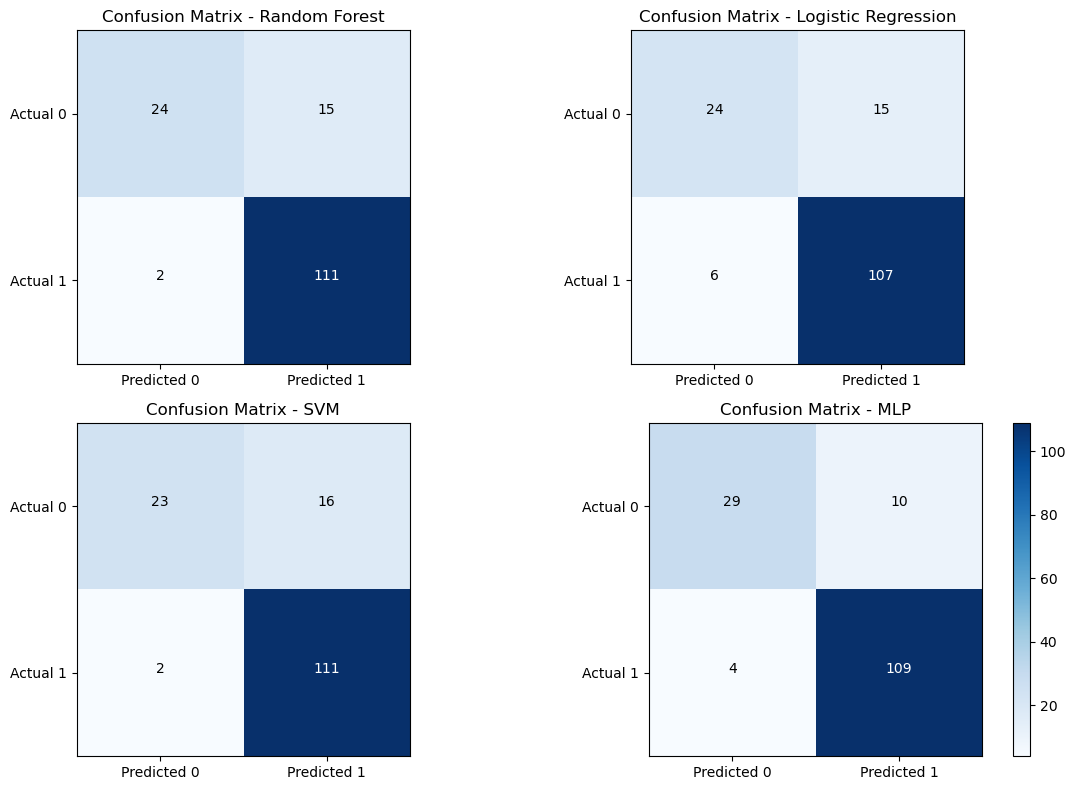

In [78]:
conf_matrices = [
    [[24, 15], [2, 111]],  # RF
    [[24, 15], [6, 107]],  # Logistic Regression
    [[23, 16], [2, 111]],  # SVM
    [[29, 10], [4, 109]]   # MLP
]

model_names = ['Random Forest', 'Logistic Regression', 'SVM', 'MLP']

plt.figure(figsize=(12, 8))

for i, conf_matrix in enumerate(conf_matrices):
    plt.subplot(2, 2, i + 1)
    plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.title(f'Confusion Matrix - {model_names[i]}')

    plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
    plt.yticks([0, 1], ['Actual 0', 'Actual 1'])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i][j] > 100 else 'black')

plt.tight_layout()
plt.colorbar()
plt.show()

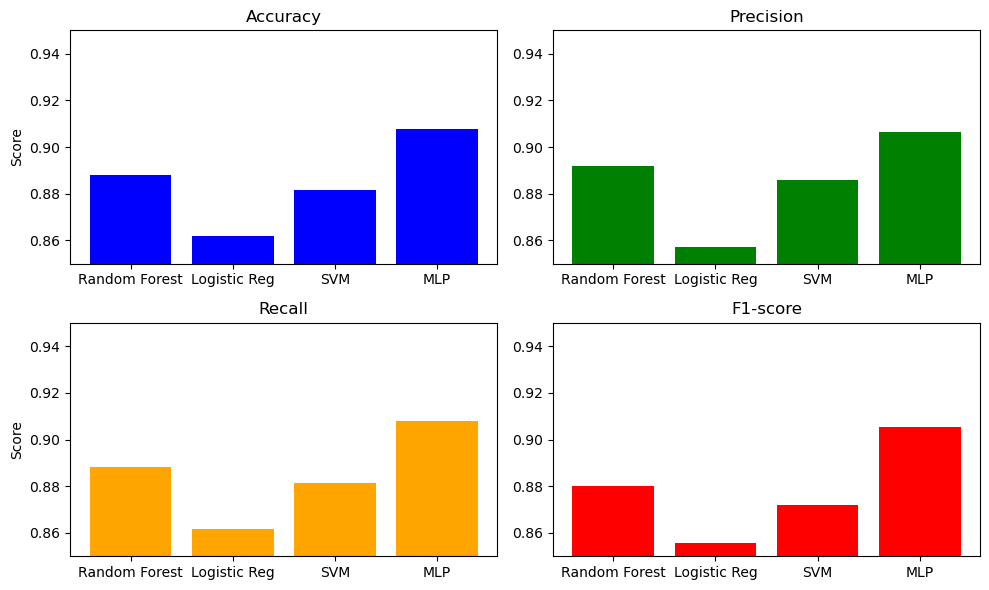

In [79]:
accuracy_scores = [0.8881578947368421, 0.8618421052631579, 0.881578947368421, 0.9078947368421053]
precision_scores = [0.8917606516290726, 0.8572799827437445, 0.885814338997099, 0.9064271641671022]
recall_scores = [0.8881578947368421, 0.8618421052631579, 0.881578947368421, 0.9078947368421053]
f1_scores = [0.8800154151068046, 0.855477384488047, 0.872080592105263, 0.905248033877798]

models = ['Random Forest', 'Logistic Reg', 'SVM', 'MLP']

plt.figure(figsize=(10, 6))

# accuracy plot
plt.subplot(2, 2, 1)
plt.bar(models, accuracy_scores, color='blue')
plt.title('Accuracy')
plt.ylim([0.85, 0.95])
plt.ylabel('Score')

# precision plot
plt.subplot(2, 2, 2)
plt.bar(models, precision_scores, color='green')
plt.title('Precision')
plt.ylim([0.85, 0.95])

# recall plot
plt.subplot(2, 2, 3)
plt.bar(models, recall_scores, color='orange')
plt.title('Recall')
plt.ylim([0.85, 0.95])
plt.ylabel('Score')

# f1-score plot
plt.subplot(2, 2, 4)
plt.bar(models, f1_scores, color='red')
plt.title('F1-score')
plt.ylim([0.85, 0.95])

plt.tight_layout()
plt.show()

## Permutation Importance

In [80]:
# random forest model
perm_importance_rf = permutation_importance(rf_classifier, X_test, y_test, n_repeats=20, random_state=28)
feature_importance_rf = perm_importance_rf.importances_mean
sorted_indices_rf = np.argsort(feature_importance_rf)[::-1]
sorted_features_rf = np.array(X.columns)[sorted_indices_rf]

# logistic regression model
perm_importance_lr = permutation_importance(logreg_classifier, X_test, y_test, n_repeats=20, random_state=28)
feature_importance_lr = perm_importance_lr.importances_mean
sorted_indices_lr = np.argsort(feature_importance_lr)[::-1]
sorted_features_lr = np.array(X.columns)[sorted_indices_lr]

# svm model
perm_importance_svm = permutation_importance(svm_classifier, X_test, y_test, n_repeats=20, random_state=28)
feature_importance_svm = perm_importance_svm.importances_mean
sorted_indices_svm = np.argsort(feature_importance_svm)[::-1]
sorted_features_svm = np.array(X.columns)[sorted_indices_svm]

# mlp model
perm_importance_mlp = permutation_importance(mlp_classifier, X_test, y_test, n_repeats=20, random_state=28)
feature_importance_mlp = perm_importance_mlp.importances_mean
sorted_indices_mlp = np.argsort(feature_importance_mlp)[::-1]
sorted_features_mlp = np.array(X.columns)[sorted_indices_mlp]

Top 5 features for Random Forest Classifier:
PC1: 0.08881578947368424
PC6: 0.013157894736842169
PC7: 0.005921052631578982
PC21: 0.003947368421052677
PC23: 0.001315789473684248
Top 5 features for Logistic Regression Classifier:
PC1: 0.1526315789473684
PC6: 0.08684210526315783
PC7: 0.0407894736842105
PC5: 0.017763157894736824
PC15: 0.016447368421052634
Top 5 features for SVM Classifier:
PC1: 0.12631578947368416
PC6: 0.03552631578947364
PC15: 0.024999999999999967
PC8: 0.015131578947368374
PC7: 0.01381578947368418
Top 5 features for MLP Classifier:
PC1: 0.13815789473684212
PC6: 0.12434210526315792
PC3: 0.06381578947368428
PC7: 0.05789473684210532
PC2: 0.051973684210526394


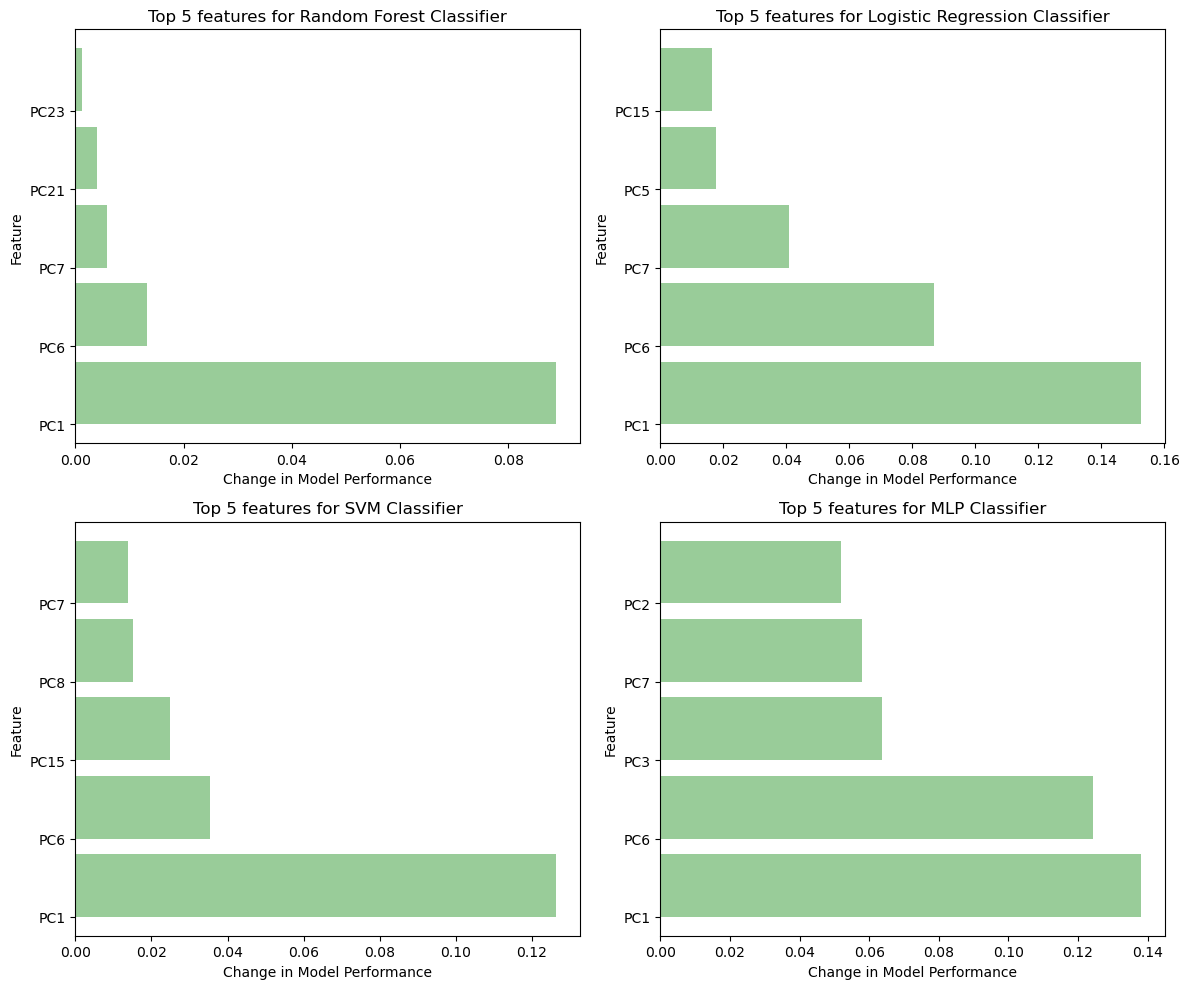

In [81]:
models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": logreg_classifier,
    "SVM": svm_classifier,
    "MLP": mlp_classifier
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for ax, (model_name, model) in zip(axs.flatten(), models.items()):
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=28)
    feature_importance = perm_importance.importances_mean
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_features = np.array(X.columns)[sorted_indices]
    
    print(f"Top 5 features for {model_name} Classifier:")
    for feature, importance in zip(sorted_features[:5], feature_importance[sorted_indices][:5]):
        print(f"{feature}: {importance}")
    
    ax.barh(range(5), feature_importance[sorted_indices][:5], align='edge', color="green", alpha=0.4)
    ax.set_yticks(range(5))
    ax.set_yticklabels(sorted_features[:5])
    ax.set_xlabel('Change in Model Performance')
    ax.set_ylabel('Feature')
    ax.set_title(f'Top 5 features for {model_name} Classifier')

plt.tight_layout()
plt.show()

### PCA Features -> Original Features

In [54]:
loadings = pca.components_

print("Shape of X_selected:", og_df.drop(columns=['class']).shape)
print("Number of components:", pca.components_.shape)

loadings_df = pd.DataFrame(loadings, columns=og_df.drop(columns=['class']).columns)
pc1_loadings = loadings_df.loc[0]
pc6_loadings = loadings_df.loc[5]
pc7_loadings = loadings_df.loc[6]

pc1_sorted_loadings = pc1_loadings.abs().sort_values(ascending=False)
pc6_sorted_loadings = pc6_loadings.abs().sort_values(ascending=False)
pc7_sorted_loadings = pc7_loadings.abs().sort_values(ascending=False)

print("Top contributing features for PC1:")
print(pc1_sorted_loadings.head())
print("\nTop contributing features for PC6:")
print(pc6_sorted_loadings.head())
print("\nTop contributing features for PC7:")
print(pc7_sorted_loadings.head())

Shape of X_selected: (756, 754)
Number of components: (25, 754)
Top contributing features for PC1:
app_LT_entropy_shannon_6_coef    0.081967
app_LT_entropy_shannon_5_coef    0.081950
app_LT_TKEO_mean_10_coef         0.081896
app_LT_entropy_shannon_7_coef    0.081884
app_LT_TKEO_std_10_coef          0.081877
Name: 0, dtype: float64

Top contributing features for PC6:
tqwt_TKEO_mean_dec_34          0.113024
tqwt_TKEO_std_dec_34           0.106883
tqwt_entropy_shannon_dec_34    0.106001
tqwt_energy_dec_32             0.105536
tqwt_maxValue_dec_21           0.105250
Name: 5, dtype: float64

Top contributing features for PC7:
std_5th_delta          0.125819
std_6th_delta          0.122875
std_5th_delta_delta    0.121240
std_MFCC_5th_coef      0.120537
std_6th_delta_delta    0.117992
Name: 6, dtype: float64


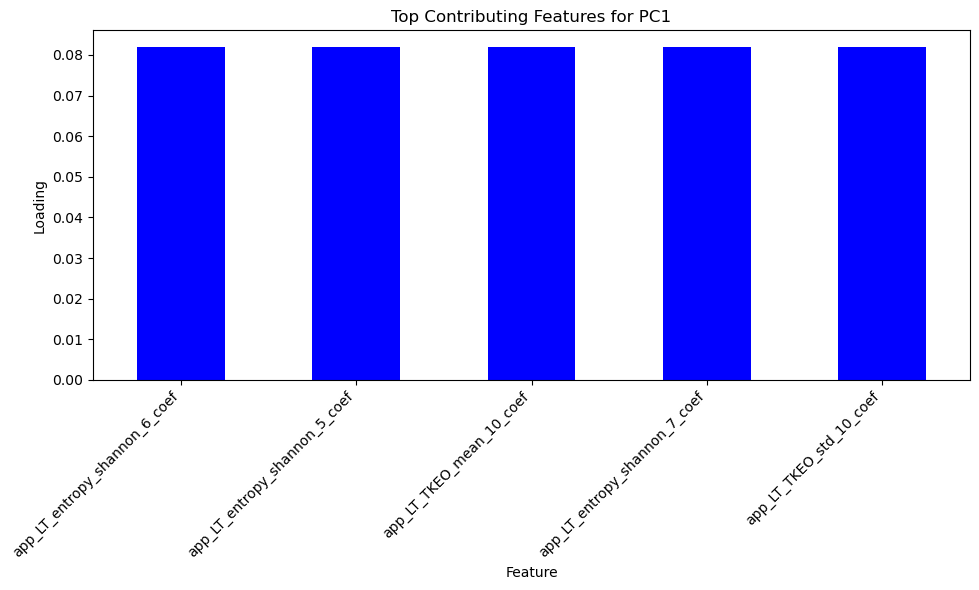

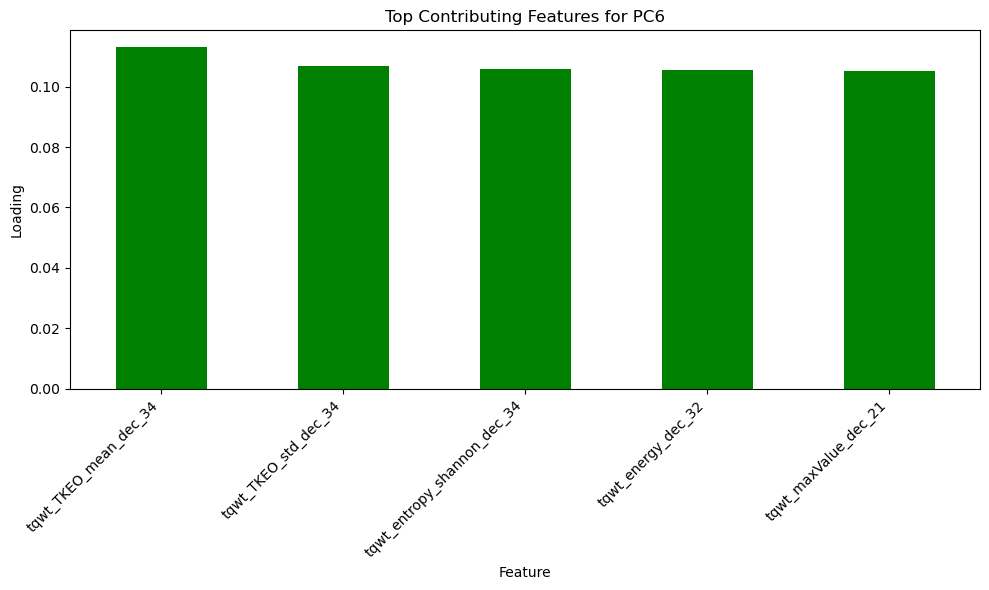

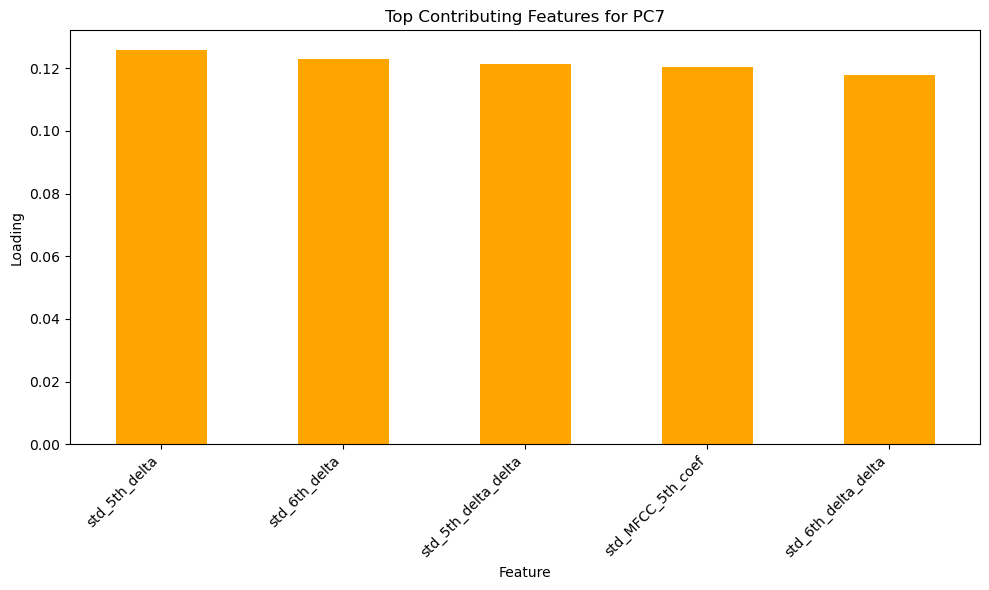

In [55]:
pc1_features = pc1_sorted_loadings.head()
pc6_features = pc6_sorted_loadings.head()
pc7_features = pc7_sorted_loadings.head()

plt.figure(figsize=(10, 6))
pc1_features.plot(kind='bar', color='blue')
plt.title('Top Contributing Features for PC1')
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
pc6_features.plot(kind='bar', color='green')
plt.title('Top Contributing Features for PC6')
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
pc7_features.plot(kind='bar', color='orange')
plt.title('Top Contributing Features for PC7')
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()